# GAN book generator

By [Allison Parrish](http://www.decontextualize.com/)

This notebook takes a three models trained with [this GAN code](https://github.com/aparrish/word-dcgan) and lays them out into something that looks like a book.

## Preliminaries

I need Pillow and Keras to make all of this work, plus numpy for random numbers and matplotlib inline to display images inline (for testing).

In [122]:
import PIL
from PIL import Image, ImageDraw, ImageFont
import keras
import numpy as np
import random
from IPython.display import display

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

## Loading the models

I wanted to be able to plausibly make sentence-like things, which meant that I needed three models: one to produce words with initial capitals (for the beginning of sentences), one to produce words with trailing punctuation (for the end of sentences), and one to produce lowercase words (for the middle of sentences). You can [download my pre-trained models](http://static.decontextualize.com/word-gan-book-generator-pretrained.zip). (For the following lines to work, you'll want to put them in a directory named `trained-models`.) Below I load all three.

In [3]:
lc_gan = keras.models.load_model("trained-models/2019-11-27T21:01:17-08000-generator.h5")

/Users/allison/anaconda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
punct_gan = keras.models.load_model("trained-models/2019-11-27T21:04:16-08000-generator.h5")

/Users/allison/anaconda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
ucfirst_gan = keras.models.load_model("trained-models/2019-11-27T21:06:33-08000-generator.h5")

/Users/allison/anaconda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


I assume all of the models have the same number of dimensions in the latent space:

In [7]:
zdim = lc_gan.input_shape[1]

## Drawing a word

The `cropped_word_image()` function below produces a word image from the specified GAN model at using the given vector. (Usually you'll want to sample a vector from a normal distribution.) I trained the GAN on very wide images in order to accommodate long words, with the words themselves drawn on the left side of the image. The `x_extent()` function attempts to crop the images returned from the GAN to only show the actual words and not the extra space to the right of the word.

In [9]:
def x_extent(im, window=4, start=32):
    for col in range(start, im.width):
        crop = im.crop((col, 0, col+window, im.height))
        if np.all(np.array(crop) > 200):
            return col
    return im.width

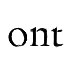

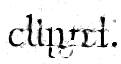

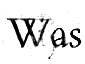

In [10]:
def cropped_word_image(gan, vec):
    generated = (gan.predict(vec) * 0.5 + 0.5) * 255
    generated[generated > 230] = 255 # simple denoising haha
    im = Image.fromarray(generated[0,:,:,0], 'F')
    offset = x_extent(im)
    return im.convert('RGB').crop((12, 0, x_extent(im)+4, im.height))
mu = 0
sigma = 1.0
display(cropped_word_image(lc_gan, sigma*np.random.randn(1,zdim)+mu))
display(cropped_word_image(punct_gan, sigma*np.random.randn(1,zdim)+mu))
display(cropped_word_image(ucfirst_gan, sigma*np.random.randn(1,zdim)+mu))

## A few utilities

The `t_normal()` function draws a random number from a truncated normal distribution. You specify the minimum and maximum range of numbers along with the center/scale of the normal distribution. (Mostly I use this to ensure that random numbers aren't negative.)

In [17]:
from scipy.stats import truncnorm
def t_normal(a, b, mu, sigma):
    tn = truncnorm((a-mu)/sigma, (b-mu)/sigma, loc=mu, scale=sigma)
    return tn.rvs(1)[0]

And `list_partition` attempts to roughly divide up a list of length *n* entries into segments of lengths determined by a normal distribution. (I am sure there's a cleaner way to do this but this solution works fine and it's NaNoGenMo so I didn't have time to think much more about it!)

In [18]:
def list_partition(n, mu, sigma, min_=2, max_=50):
    current = 0
    while True:
        current += int(t_normal(min_, max_, mu, sigma))
        if current < n:
            yield current
        else:
            break

The function evaluates to a list of indices in a list of length *n* that form boundaries between the partitions.

In [19]:
list(list_partition(100, 26, 18))

[18, 44, 67, 88]

## Generating token types and vectors

My model of a "novel" for the purposes of this project is the following:

* A novel is composed of a number of chapters
* A chapter is composed of a title and a number of sentences
* A sentence is composed of a word in an initial capital, followed by some number of lowercase words, followed by a lowercase word with following punctuation

The `generate_token_types()` function implements the "chapter" portion of this model. It yields a sequence of strings that can be seen as a list of instructions for the chapter layout algorithm.

In [20]:
def generate_token_types(n=1000, mu=26, sigma=18):
    types = ["lc"] * n
    types[0] = "ucfirst"
    types[-1] = "randpunct"
    parts = list_partition(n, mu, sigma)
    for i in parts:
        types[i] = "ucfirst"
        if i > 0 and types[-1] != 'ucfirst':
            types[i-1] = "randpunct"
    with_paras = ["newpara"] * 4
    with_paras += ["ucfirst"] + (["lc"] * random.randrange(5))
    with_paras += ["newpara"] * 4
    for i, item in enumerate(types):
        with_paras.append(item)
        if item == 'randpunct' and int(t_normal(0, 12, 5, 5)) < 5 and i < len(types) - 2:
            with_paras.append("newpara")
            with_paras.append("indent")
    for item in with_paras:
        yield item

In [22]:
list(generate_token_types(n=25))

['newpara',
 'newpara',
 'newpara',
 'newpara',
 'ucfirst',
 'lc',
 'lc',
 'newpara',
 'newpara',
 'newpara',
 'newpara',
 'ucfirst',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'lc',
 'randpunct']

The novel also includes an "introductory" section, which I meant to look like a dedication or epigraph. That has slightly different rules, implemented in `intro_tok_type_gen()`:

In [24]:
def intro_tok_type_gen():
    d = ["newpara", "newpara", "newpara", "newpara", "ucfirst"]
    d += [random.choice(["lc", "ucfirst"]) for i in range(int(t_normal(2, 16, 5, 3)))]
    if random.randrange(2) == 0:
        d += ["randpunct"]
    for item in d:
        yield item

In [25]:
list(intro_tok_type_gen())

['newpara',
 'newpara',
 'newpara',
 'newpara',
 'ucfirst',
 'lc',
 'lc',
 'ucfirst',
 'ucfirst',
 'randpunct']

Finally, I want to be able to generate an all-lowercase model book, in addition to the "novel." The following function simply yields lowercase instructions *n* times:

In [26]:
def all_lc_type_gen(n=1000):
    for i in range(n):
        yield "lc"

I also need to supply a sequence of vectors to feed into the GAN models. For the novel, I just use normally-distributed random numbers. The `normal_gen()` function yields these forever:

In [67]:
def normal_gen():
    while True:
        yield np.random.randn(1, 128)

For the all-lowercase book, I use a sequence of interpolations between normal samples:

In [177]:
def interp_gen():
    src = np.random.randn(1, 128)
    while True:
        steps = int(t_normal(3, 50, 8, 4))
        dest = np.random.randn(1, 128)
        for j in range(steps+1):
            yield(src*(1-(j/steps)) + dest*(j/steps))
        src = dest

## Page layout

So how to turn the GAN samples into a book? I could have just saved the images and included them in an HTML or LaTeX layout. But it's difficult to make an HTML layout that produces a quality printed book, and I couldn't find anything in the LaTeX documentation that made me feel confident that it could lay out inline images as well as it can lay out words. So I decided to do the layout on my own by copying the sampled images directly into blank bitmaps with Pillow. The functions in this section implement these (limited) layout capabilities.

The most important step of any kind of page layout is having a page to put things on:

In [69]:
def blank_page(width_in, height_in, dpi):
    page_width = int(dpi*width_in)
    page_height = int(dpi*height_in)
    return Image.new('RGB', (page_width, page_height), color="rgb(255,255,255)")

A minimal title page layout:

In [70]:
def gen_title_page(lc_gan, ucfirst_gan, punct_gan, width_in, height_in, margin_in, dpi):
    
    page_width = int(dpi * width_in)
    page_height = int(dpi * height_in)
    margin_width = int(margin_in * dpi)
    
    # title-esque, author-oid, publisher-like
    lines = []
    line_widths = []
    for i in range(3):
        line = [cropped_word_image(ucfirst_gan, np.random.randn(1,128))
                  for i in range(int(t_normal(1, 6, 2, 2)))]
        width = sum([im.width for im in line])
        lines.append(line)
        line_widths.append(width)

    page = blank_page(width_in, height_in, dpi)
    
    # draw lines 0 & 1 at 1.5 size
    center_offset = (page_width / 2) - (line_widths[0] * 0.75)
    for word in lines[0]:
        resized = word.resize((int(word.width*1.5), int(word.height*1.5)), PIL.Image.LANCZOS)
        page.paste(resized, (int(center_offset), int(page_height / 3)))
        center_offset += word.width * 1.5
        
    # draw line 1 at 1.5 size
    center_offset = (page_width / 2) - (line_widths[1] * 0.75)
    for word in lines[1]:
        resized = word.resize((int(word.width*1.5), int(word.height*1.5)), PIL.Image.LANCZOS)
        page.paste(resized, (int(center_offset), int((page_height / 3) + (0.5*dpi))))
        center_offset += word.width * 1.5
        
    # draw line 2 at normal size
    center_offset = (page_width / 2) - (line_widths[2] * 0.5)
    for word in lines[2]:
        page.paste(word, (int(center_offset), int(page_height - margin_width)))
        center_offset += word.width
    
    return page

Here's an example (resized to fit nicely in the notebook):

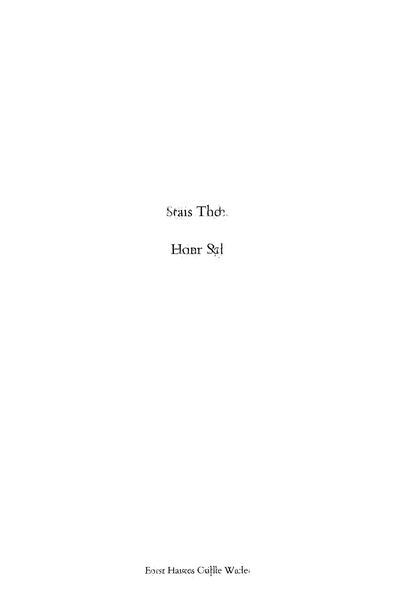

In [65]:
title_page_test = gen_title_page(lc_gan, ucfirst_gan, punct_gan, width_in=5.25, height_in=8, margin_in=0.5, dpi=320)
display(title_page_test.resize((394,600), PIL.Image.LANCZOS))

Generating chapters is a bit more difficult. The `gen_pages_chapter()` function yields a sequence of pages in which words are laid out in lines across the page, following instructions provided by the generator supplied as the `token_type_generator` parameter and using vectors proviced by generator supplied as the `vec_generator` parameter. The function implements full justification in a very rudimentary way: the difference between the sum of the word's widths and the width of the text box is distributed evenly as spacing between each word.

The function also keeps track of whether or not a page is verso or recto and adds a gutter to the left or right side of the page accordingly. (The `flip` function is a little convenience function to get the side of the page opposite to the one specified.)

In [71]:
def flip(side):
    return "verso" if side == "recto" else "recto"
print(flip("verso"))
print(flip("recto"))

recto
verso


In [101]:
import random
def gen_pages_chapter(lc_gan, ucfirst_gan, punct_gan, vec_generator, token_type_generator,
              dpi=320, width_in=6, height_in=9, margin_in=0.75, gutter_in=0.25, indent_in=0.25,
              start_side="recto"):
    
    page_width = int(dpi*width_in)
    page_height = int(dpi*height_in)
    margin_width = int(margin_in * dpi)
    gutter_width = int(gutter_in * dpi)
    indent_width = int(indent_in * dpi)
    text_width = page_width - (margin_width*2) - gutter_width
    text_height = page_height - (margin_width*2) - gutter_width
    
    line_incr = int((14 / 72) * dpi)
    lines = []
    current_line = []
    is_indent = False
    cur_x = 0
    
    # build lines as a list of 2-tuples: (line_type, list_of_words)
    while True:
        try:  # get the next token type from the generator
            tok_type = next(token_type_generator)
        except StopIteration:
            lines.append(('endpara', current_line[:]))
            break
        #print(tok_type, end=" ")
        # important part: add a word sampled from the appropriate GAN
        if tok_type == 'ucfirst':
            word = cropped_word_image(ucfirst_gan, next(vec_generator))
        elif tok_type == 'randpunct':
            word = cropped_word_image(punct_gan, next(vec_generator))
        elif tok_type == 'lc':
            word = cropped_word_image(lc_gan, next(vec_generator))
        # newpara token: end the current line
        elif tok_type == 'newpara':
            lines.append(('endpara', current_line[:]))
            current_line = []
            cur_x = 0
            continue
        # indent token: add a special blank indent "word" image
        elif tok_type == 'indent':
            word = Image.new('RGB', (indent_width, line_incr), color="rgb(255,255,255)")
            is_indent = True

        # if the running width plus this word would exceed width of the text box...
        if cur_x + word.width > text_width:
            if is_indent:
                lines.append(('indent', current_line[:]))
                is_indent = False
            else:
                lines.append(('regular', current_line[:]))
            current_line = []
            cur_x = 0
        current_line.append(word)
        cur_x += word.width
    
    page = blank_page(width_in, height_in, dpi)
    yoff = 0
    current_side = start_side
    
    # blit lines, yielding new pages as necessary
    for i, (kind, line) in enumerate(lines):
        if kind == 'regular' and len(line) > 1:
            word_width_sum = sum([w.width for w in line])
            spacing = [(text_width - word_width_sum) / (len(line) - 1)] * len(line)
        # indented lines' spacing determined from length of words following indent
        elif kind == 'indent':
            word_width_sum = sum([w.width for w in line[1:]])
            spacing = [0] + [(text_width - word_width_sum - line[0].width) / (len(line) - 2)] * (len(line) - 1)
        else:
            spacing = [0] * len(line)
        #print(kind, spacing)

        if current_side == "recto":
            xoff = margin_width + gutter_width
        else:
            xoff = margin_width
            
        # blit words onto the page for this line
        for word, space in zip(line, spacing):
            page.paste(word, (int(xoff), int(yoff)+margin_width))
            xoff += word.width + space
        # move to next line
        yoff += line_incr
        # if this would be below the bottom margin...
        if yoff + line_incr > text_height:
            yield page
            yoff = 0
            current_side = flip(current_side)
            page = blank_page(width_in, height_in, dpi)
    if yoff > 0: # yield non-empty pages
        yield page

Here's what it looks like:

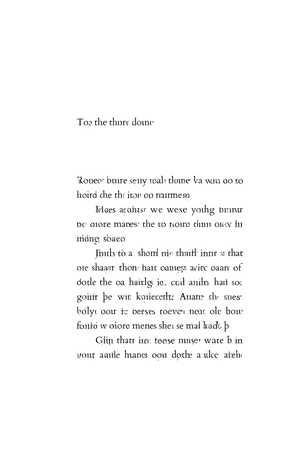

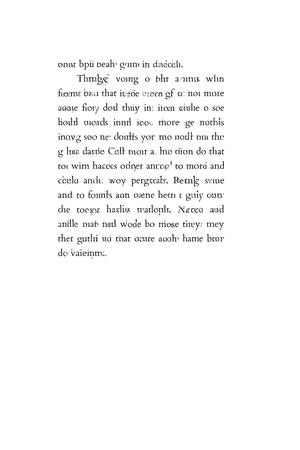

In [98]:
chapter_pages_test = list(gen_pages_chapter(
    lc_gan, ucfirst_gan, punct_gan,
    normal_gen(),
    generate_token_types(n=200),
    width_in=4,
    height_in=6,
    indent_in=0.25,
    margin_in=0.75,
    gutter_in=0.25,
    dpi=320
))
for page in chapter_pages_test:
    display(page.resize((300,450), PIL.Image.LANCZOS))

Or with all-lowercase interpolation:

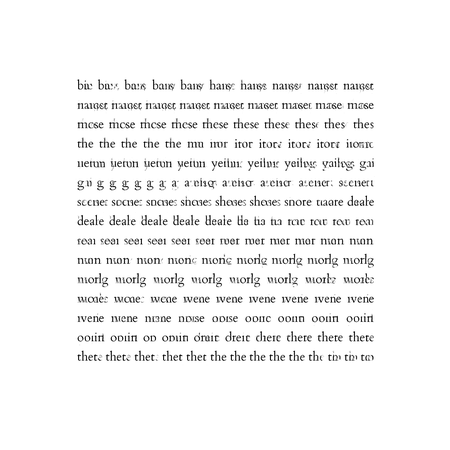

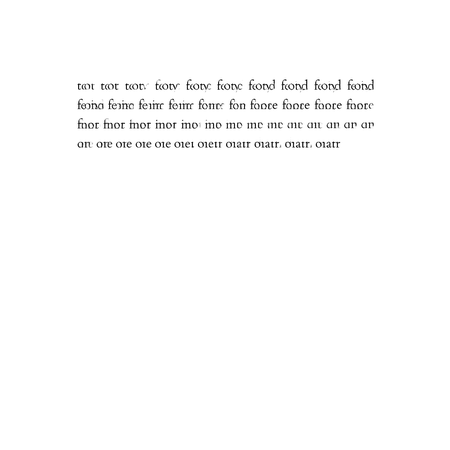

In [99]:
chapter_pages_test = list(gen_pages_chapter(
    lc_gan, ucfirst_gan, punct_gan,
    interp_gen(),
    all_lc_type_gen(n=200),
    width_in=4.5,
    height_in=4.5,
    indent_in=0,
    margin_in=0.75,
    gutter_in=0,
    dpi=320
))
for page in chapter_pages_test:
    display(page.resize((450,450), PIL.Image.LANCZOS))

## Generating the novel

For NaNoGenMo, I want to generate a "novel" of fifty thousand "words." To do this, I first set some sizes and metrics for the page layout (5.25"x8", 0.75in margins, 320 dpi to make the text from the model appear to be around 12pts tall):

In [165]:
width_in = 5.25
height_in = 8
indent_in = 12.0 / 72
margin_in = 0.75
gutter_in = 0.25
dpi = 320  # 40px text will end up ~12pts

Then I create a list of chapter lengths:

In [109]:
#chap_word_offsets = list(list_partition(500, 200, 25, 50, 500))
#chap_lens = [j - i for i, j in zip([0]+chap_word_offsets, chap_word_offsets+[500])]
chap_word_offsets = list(list_partition(50000, 2000, 1500, 200, 6000))
chap_lens = [j - i for i, j in zip([0]+chap_word_offsets, chap_word_offsets+[50000])]

In [110]:
print(chap_lens)
sum(chap_lens)

[265, 3001, 1962, 3857, 212, 3552, 4047, 1893, 2872, 1372, 1723, 639, 2900, 2577, 3090, 3569, 1615, 832, 3778, 1406, 1582, 660, 681, 1915]


50000

And then run the following cell to generate the novel. (This will take a while.)

In [111]:
all_pages = []
print("title page")
title_page = gen_title_page(lc_gan, ucfirst_gan, punct_gan,
                            width_in, height_in, margin_in, dpi)
all_pages.append(title_page)
all_pages.append(blank_page(width_in, height_in, dpi))
print("intro page")
intro_page = list(gen_pages_chapter(
    lc_gan, ucfirst_gan, punct_gan,
    normal_gen(),
    intro_tok_type_gen(),
    width_in=width_in,
    height_in=height_in,
    indent_in=indent_in,
    margin_in=margin_in*2,
    gutter_in=gutter_in,
    dpi=dpi
))[0]
all_pages.append(intro_page)
all_pages.append(blank_page(width_in, height_in, dpi))
print("chapters")
current_side = "recto"
for i, chap_len in enumerate(chap_lens):
    print()
    print("---> chapter", i+1, "/", len(chap_lens), "(with", chap_len, "words)")
    print()
    pages = list(gen_pages_chapter(
        lc_gan, ucfirst_gan, punct_gan,
        normal_gen(),
        generate_token_types(n=chap_len),
        width_in=width_in,
        height_in=height_in,
        indent_in=indent_in,
        margin_in=margin_in,
        gutter_in=gutter_in,
        dpi=dpi,
        start_side=current_side))
    if len(pages) % 2 == 1:  # odd number of pages means we're starting on the other side
        current_side = flip(current_side)
    all_pages.extend(pages)
print("done!")

title page
intro page
chapters

---> chapter 1 / 24 (with 265 words)


---> chapter 2 / 24 (with 3001 words)


---> chapter 3 / 24 (with 1962 words)


---> chapter 4 / 24 (with 3857 words)


---> chapter 5 / 24 (with 212 words)


---> chapter 6 / 24 (with 3552 words)


---> chapter 7 / 24 (with 4047 words)


---> chapter 8 / 24 (with 1893 words)


---> chapter 9 / 24 (with 2872 words)


---> chapter 10 / 24 (with 1372 words)


---> chapter 11 / 24 (with 1723 words)


---> chapter 12 / 24 (with 639 words)


---> chapter 13 / 24 (with 2900 words)


---> chapter 14 / 24 (with 2577 words)


---> chapter 15 / 24 (with 3090 words)


---> chapter 16 / 24 (with 3569 words)


---> chapter 17 / 24 (with 1615 words)


---> chapter 18 / 24 (with 832 words)


---> chapter 19 / 24 (with 3778 words)


---> chapter 20 / 24 (with 1406 words)


---> chapter 21 / 24 (with 1582 words)


---> chapter 22 / 24 (with 660 words)


---> chapter 23 / 24 (with 681 words)


---> chapter 24 / 24 (with 1915 words)



Phew! Make a directory for the output...

In [88]:
!mkdir output

mkdir: output: File exists


Then save the pages to PNG (taking care to specify the DPI):

In [112]:
for i, page in enumerate(all_pages):
    #display(page)
    if i % 10 == 0:
        print(i)
    page.save("output/novel-page-%03d.png" % i, dpi=(dpi,dpi))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


Now generate a little page in the back to give the book attribution. (You'll need to download [Cardo](https://fonts.google.com/specimen/Cardo)'s TrueType font file for this cell to work.)

In [158]:
lastpage = blank_page(width_in, height_in, dpi)
draw = ImageDraw.Draw(lastpage)
draw.multiline_text(
    (margin_in*dpi, (height_in-margin_in-0.25)*dpi),
    "Allison Parrish 2019\nhttp://www.decontextualize.com/",
    fill="rgb(0,0,0)",
    font=ImageFont.truetype("Cardo-Regular.ttf", size=24))
lastpage.save("output/novel-page-last.png", dpi=(dpi, dpi))

Then I use [img2pdf](https://gitlab.mister-muffin.de/josch/img2pdf) to convert all of the files to PDF:

In [176]:
!img2pdf -o novel.pdf output/novel-page*.png

## Generating the interpolation "art book"

I'm also interested in interpolation as an aesthetic, and the GANs I trained produce interesting and satisfying interpolations between word forms. This section generates an "art book" with interpolations over a random number of steps between random samples from the model's latent space. It doesn't aim for any visual verisimilitude to a "novel" and I don't think it's interesting for fifty thousand words. So this one has fewer words and I'm calling it an "art book." Sure!

In [161]:
width_in = 5.25
height_in = 5.25
indent_in = 0
margin_in = 0.75
gutter_in = 0
dpi = 320  # 40px text will end up ~12pts

In [114]:
pages = list(gen_pages_chapter(
    lc_gan, ucfirst_gan, punct_gan,
    interp_gen(),
    all_lc_type_gen(n=10000),
    width_in=width_in,
    height_in=height_in,
    indent_in=indent_in,
    margin_in=margin_in,
    gutter_in=gutter_in,
    dpi=dpi,
    start_side=current_side))

In [115]:
for i, page in enumerate(pages):
    #display(page)
    if i % 10 == 0:
        print(i)
    page.save("output/interpolation-page-%03d.png" % i, dpi=(dpi,dpi))

0
10
20
30


In [162]:
lastpage = blank_page(width_in, height_in, dpi)
draw = ImageDraw.Draw(lastpage)
draw.multiline_text(
    (margin_in*dpi, (height_in-margin_in-0.25)*dpi),
    "Allison Parrish 2019\nhttp://www.decontextualize.com/",
    fill="rgb(0,0,0)",
    font=ImageFont.truetype("Cardo-Regular.ttf", size=24))
lastpage.save("output/interpolation-page-last.png", dpi=(dpi, dpi))

In [163]:
!img2pdf -o interpolations.pdf output/interpolation-page*.png

And done!